# TDA Analysis


## Import libraries

In [10]:
import kmapper as km
from kmapper.plotlyviz import *
import pandas as pd
import numpy as np

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Upload data

In [11]:
water20 = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
water20 = water20[["SHEETBAR", "DATE", "LATITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
"TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI", "YEAR", "SEASON"]]

## Scale data

In [12]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

ct = ColumnTransformer([('somename', RobustScaler(), continuous_variables)], remainder = 'passthrough')

water_df = ct.fit_transform(water20)

water_df = pd.DataFrame(water_df, columns = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal",
                                             "SHEETBAR", "DATE", "LATTITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
                                             "YEAR", "SEASON"])  

## Make decade columns


In [13]:
eco_time_periods = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

for time_period in eco_time_periods:
    begin_year = int(time_period[0:4])
    end_year = int(time_period[5:9])
    
    water_df[time_period] = np.where((water_df['YEAR'] >= begin_year) & (water_df['YEAR'] <= end_year), 1, 0)

## Make dummy columns

In [14]:
to_dummy_vars = ['STRATUM', 'FLDNUM']

for var in to_dummy_vars:
    temp = pd.get_dummies(water_df[var])
    water_df = pd.concat([water_df, temp], axis = 1)

## Make coloring columns for continuous variables

In [15]:
for variable in continuous_variables:
    column_name =  variable + "_color" 

    q25, q75 = np.percentile(water_df[variable], [25, 75])
    iqr = q75 - q25

    ceiling = water_df[variable].quantile(.75) + (3 * iqr)

    water_df[column_name] = np.where(water_df[variable] >= ceiling, ceiling, water_df[variable])

# Run kmapper

## Make the kmapper scomplex

In [31]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
X = water_df#[continuous_variables]

var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
projected_var_indices = [var_to_index[var] for var in continuous_variables]

X.reset_index(drop = True, inplace = True)

cluster_alg = sklearn.cluster.DBSCAN(eps = 1.2, min_samples = 20, metric = 'euclidean')
#cluster_alg = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 10)
pca = PCA(n_components = 2)
lens = pca.fit_transform(X[continuous_variables])

mapper = km.KeplerMapper(verbose = 0)
scomplex = mapper.map(lens, X[continuous_variables], cover = km.Cover(n_cubes = [125, 125], perc_overlap = [.4, .4]), 
                                            clusterer = cluster_alg, remove_duplicate_nodes = True)


## Calculate the node densitites for each node in the scomplex

### Functions

In [18]:
from sklearn.neighbors import NearestNeighbors
import queue

In [19]:
def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex)
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result

def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes

def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

In [33]:
#scomplex = scomplex_dict.get(key)
scomplex['density'] = {}
largestShape = clean_getShapes(scomplex)[0]
#print("Largest shape is: ", largestShape, "\n")
largestShape_df = getSubdf(scomplex, largestShape, X[continuous_variables])
k = int((X.shape[0] / 10) + 1)
for node_name in largestShape:
    #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
    scomplex['density'][node_name] = calculate_density(scomplex, node_name, X[continuous_variables], k)

allComplices = list(scomplex_dict.keys())
df = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
df = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]

for key in allComplices: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = scomplex_dict.get(key)
    scomplex['density'] = {}
    largestShape = clean_getShapes(scomplex)[0]
    #print("Largest shape is: ", largestShape, "\n")
    largestShape_df = getSubdf(scomplex, largestShape, df_dict.get(key))
    k = int((df_dict.get(key).shape[0] / 10) + 1)
    for node_name in largestShape:
        #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
        scomplex['density'][node_name] = calculate_density(scomplex, node_name, df_dict.get(key), k)

## Make digraph

### Functions

In [21]:
import networkx as nx

In [22]:
def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes):
        succ = dict(nx.bfs_successors(dg, source=node))
        if not succ[node]:
            maxima.append(node)
    return maxima

def draw_graph(scomplex, filepath, with_labels = False):
    colors = ['#00A08A', '#e80909', '#F2AD00', '#a6d96a', '#d9ef8b', '#d0e1f0', '#74a7d2',
             '#295981', '#17334a', '#a2a0f7', '#e68a0d', '#a68a52', '#50704a', '#458B74', '#817f85']
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#ffffbf'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize = (12,12))
    ax = plt.subplot(111)

    title = filepath[:-4]
    ax.set_title(title, fontsize = 60)
    
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
        else:
            color_map.append(colors_dict[states[0]])

    
    nx.draw_kamada_kawai(scomplex['graph'], with_labels = with_labels, node_color = color_map)
    plt.tight_layout()
    plt.savefig(filepath, format = "PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')

def append_states(scomplex, shape, df):
    for maximum in scomplex['maxima']:
        entries = [0 for x in range(df.shape[0])]
        for node in scomplex['states'][maximum]:
            for entry in scomplex['nodes'][node]:
                entries[entry] = 1
        df[maximum] = entries
        #water_df = pd.concat([water_df, temp], axis = 1)

In [34]:
#for key in allComplices: # remove the indices here to get all the strata for all the time periods
#scomplex = scomplex_dict.get(key)
#print(key)
largestShape = clean_getShapes(scomplex)[0]
scomplex['graph'] = {}
scomplex['graph'] = generate_graph(scomplex, largestShape)
scomplex['maxima'] = get_local_maxima(scomplex['graph'])
#print(key + ": " + str(len(scomplex['maxima'])) )

### Print out digraph with states coloring

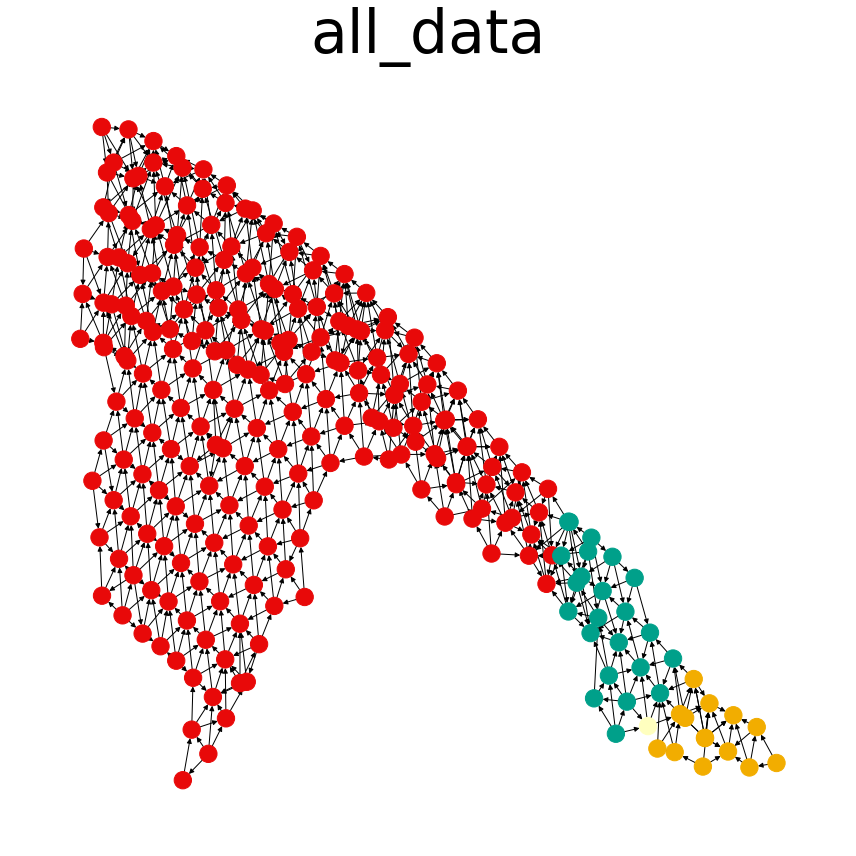

In [25]:
filepath = "all_data1.png"
draw_graph(scomplex, filepath, with_labels = False)

In [26]:
append_states(scomplex, largestShape, X)

Index(['WDP', 'SECCHI', 'TEMP', 'DO', 'TURB', 'VEL', 'TP', 'TN', 'SS',
       'CHLcal', 'cube665_cluster0', 'cube60_cluster0', 'cube828_cluster0'],
      dtype='object')

## Get coloring names lists

In [ ]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

continuous_variable_colors =  ["WDP_color", "SECCHI_color", "TEMP_color", "DO_color", 
                                "TURB_color", "VEL_color", "TP_color", "TN_color", 
                                "SS_color", "CHLcal_color"]

pool_names = ['Unexploded Ordinance Area - Pool 13',
                                        'Bellevue, IA',
                                        'Brighton, IL',
                                          'Havana, IL',
                                         'Jackson, MO',
                                       'Lake City, MN',
                                        'Onalaska, WI']

decade_names = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

stratum_names = ['Backwater area contiguous to the main channel',
                                           'Impounded',
                                            'Isolated',
                             'Lake Pepin or Swan Lake',
                                        'Main channel',
                                        'Side channel']